In [3]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split,Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.nn import Module, Sequential , ConvTranspose2d, ReLU, Tanh, BatchNorm2d
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size=1

Using cpu device


In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None, mode='GAN'):
        self.path_to_real = os.path.join('/content/drive/MyDrive/Newdata', mode,'Real_Imgs')
        self.path_to_fake = os.path.join('/content/drive/MyDrive/Newdata', mode,'Fake_Imgs')
        self.path_to_real = [os.path.join(self.path_to_real, i) for i in os.listdir(self.path_to_real)]
        self.path_to_fake = [os.path.join(self.path_to_fake, i) for i in os.listdir(self.path_to_fake)]
        self.img_dir = self.path_to_real
        self.nbre_images = len(self.img_dir)
        self.labels = np.ones(self.nbre_images)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.nbre_images

    def __getitem__(self, idx):
        image = read_image(self.img_dir[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64,64)),
            transforms.ToTensor()
            ])
switch = [transform]
trainset = CustomImageDataset(transform=switch[0]) # Creating an instance of  our class
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4) # Creating our dataloader

def plot_images(imgs, grid_size = 5):
    fig = plt.figure(figsize = (8,8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs)
    plt.show

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


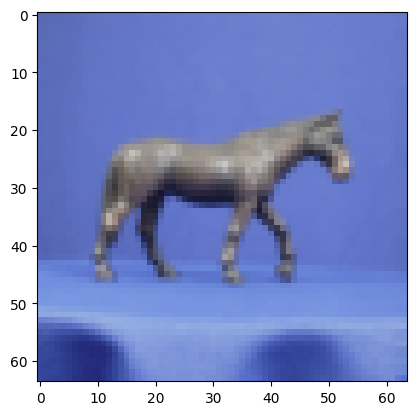

In [5]:
# Display image and label.
%matplotlib inline
train_features, train_labels = next(iter(trainloader))
img = train_features[0].permute(1,2,0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

In [6]:
nz = 10 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ngpu = 0 # Number of GPUs available. Use 0 since CPU mode.
ndf = 64 # Size of feature maps in discriminator
nc = 3   # Number of channels in the training images. For color images this is 3

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)


myGenerator = Generator(ngpu).to(device)

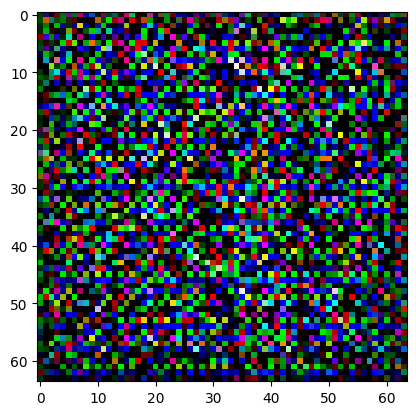

In [8]:
%matplotlib inline
noise = torch.randn(1, 10, 1,1) #random size 1x10x1x1
z = torch.randint(0, 255,(1,10), dtype=torch.float32) #return a random tensor filled with random float-32
z = myGenerator(noise.to(device)).cpu() #Generator generate an image
z = z.detach().squeeze().permute(1, 2, 0).numpy()
plt.imshow(z)
plt.show()

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)



myDiscriminator = Discriminator(ngpu).to(device)

In [10]:
def weights_init(m):  #custom weights initialization called on myGenerator and myDiscriminator
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
myGenerator.apply(weights_init)
myDiscriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(myDiscriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(myGenerator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# Initialize BCELoss function
BCELoss = nn.BCELoss()

Starting Training Loop...


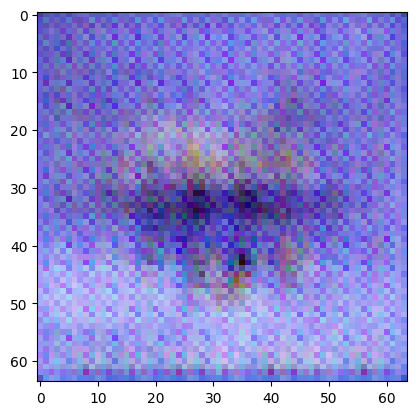

 Epoch 0 
 Completion: 0.000000 percent


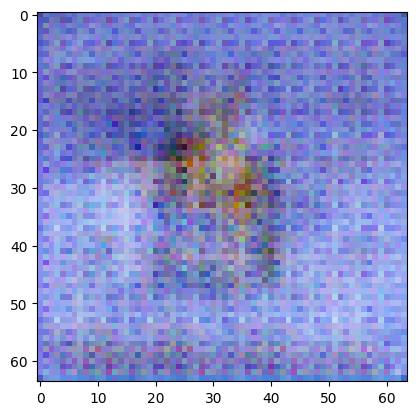

 Epoch 1 
 Completion: 0.107875 percent


In [ ]:
#Training GAN
print("Starting Training Loop...")


n_of_epochs = 927


for e in range(n_of_epochs):
    running_loss_D = 0.0
    for i, data in enumerate(trainloader, 0):

    #################################################################
    ## Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) ##
    #################################################################

        #Loss on real Images
        inputs, b = data
        myDiscriminator.zero_grad()
        predicted = myDiscriminator(inputs.to(device))
        labels = torch.ones(len(b), 1, 1,1, dtype=torch.float, device=device)# real
        loss_real = BCELoss(predicted, labels.to(device))
        loss_real.backward()

        #Loss on fake Images
        noise = torch.randn(1, 10, 1,1)
        fake_image = myGenerator(noise.to(device))
        predicted = myDiscriminator(fake_image.detach())
        target = torch.zeros(len(b),1, 1, 1, dtype=torch.float, device=device)# fake
        loss_fake = BCELoss(predicted, target)
        loss_fake.backward()
        loss_Discriminator = loss_real + loss_fake
        optimizerD.step()

    ###############################################
    ### Update Generator: maximize log(D(G(z))) ###
    ###############################################

        myGenerator.zero_grad()
        predicted = myDiscriminator(fake_image)
        target = torch.ones(1, 1, 1,1, dtype=torch.float, device=device)# real for the generator
        loss_gen = BCELoss(predicted, target)
        loss_gen.backward()
        optimizerG.step()
        running_loss_D +=  loss_Discriminator.item() 

    #################################
    ### Plotting Generated images ###
    #################################
    %matplotlib inline
    noise = torch.randn(1, 10, 1,1)
    z = myGenerator(noise.to(device))
    z = z.cpu().detach().squeeze().permute(1, 2, 0).numpy()
    plt.imshow(z)
    plt.show()
    print(" Epoch %d \n Completion: %f percent" %(e,e/n_of_epochs*100))
    #################################
    ###  Saving Generated images  ###
    #################################
    if e>227:
        fake_img=myGenerator(noise.to(device))
        save_image(fake_img,f'c:/Users/HP/Documents/Newdata/GAN/Fake_Imgs/FakeIMG_{e-227}.png')
print('Finished Training')